# Detecting obfuscated bash commands

In this Jupyter notebook, we will study a dataset comprised of bash commands and obfuscated versions of them, using machine learning to try to learn how to detect these obfuscated (and therefore likely malicious) commands. The purpose of this exercise is to demonstrate a standard supervised learning pipeline, consisting of feature extraction, creating a train/test split, training a classfier, analyzing the results, and iterating on this process until we obtain satisfactory performance.

In order to circumvent simple, signature-based detectors for suspicious commands executed in the shell, attackers may choose to obfuscate their commands using automated methods. Such tools take a normal command as input and generate a version that is functionally the same but looks significantly different, and would therefore escape detection by a signature-based detector. The obfuscation tool we will be using to generate our example dataset is Bashfuscator [1], which works with bash commands.

To generate our example dataset, we downloaded a set of normal (i.e., unobfuscated) bash commands from a project called NL2Bash [2]. This data consists of a set of ~12K bash one-liners [3] collected from websites such as StackOverflow. Using Bashfuscator and a subset of these commands, we generated ~1200 obfuscated bash commands.

### References
[1] https://github.com/Bashfuscator/Bashfuscator

[2] https://github.com/TellinaTool/nl2bash

[3] https://github.com/TellinaTool/nl2bash/blob/master/data/bash/all.cm



## Load data
For this exercise, the data collection and pre-processing steps have already been completed as described earlier, and that we only need to load this dataset in order to start using it.

Note that since we are trying to detect obfuscated bash commands, we label obfuscated commands as members of the positive class (+1) and normal (i.e., unobfuscated) ones as members of the negative class (-1). This will be significant later on when we analyze the performance of our classifiers by considering their precision, recall, false positives, false negatives, etc.

In [1]:
import os
import sys
import random

# Load raw text
nor_text = list()
mal_text = list()

# Load unobfuscated commands
sample_proportion = 1  # lower to improve class balance
my_file = 'data/bash_commands'
with open(my_file) as f:
    for i,line in enumerate(f):
        if random.random() < sample_proportion:
            cmd = line.rstrip()
            nor_text.append(cmd)

# Load obfuscated commands
my_file = 'data/obs_bash_commands'
with open(my_file) as f:
    for i,line in enumerate(f):
        cmd = line.rstrip()
        mal_text.append(cmd)

# Count number of normal and malicious commands
num_nor = len(nor_text)
num_mal = len(mal_text)
print('\nLoaded %s normal commands and %s obfuscated commmands.' % (num_nor, num_mal))


Loaded 12607 normal commands and 1272 obfuscated commmands.


### Examples from dataset
Let's first look at some examples of normal and obfuscated bash commands to better understand the task at hand. This step of manually inspecting the data and trying to understand its features and peculiarities is an important and necessary one, as it informs us on the type of model we may want to use to best solve our problem.

In [2]:
# Examples of normal bash commands
print('Normal bash examples:')
for elem in nor_text[0:10]: print('(len: ' + str(len(elem)) + ') ' + elem)

Normal bash examples:
(len: 58) top -b -d2 -s1 | sed -e '1,/USERNAME/d' | sed -e '1,/^$/d'
(len: 65) top -b -n 1 -u abc | awk 'NR>7 { sum += $9; } END { print sum; }'
(len: 100) top -b -d 5 -n 2 | awk '$1 == "PID" {block_num++; next} block_num == 2 {sum += $9;} END {print sum}'
(len: 8) top -n 1
(len: 22) top -bn1 | grep zombie
(len: 26) top -bn1 | sed -n '/Cpu/p'
(len: 57) top -bn1 | grep zombie | awk '{print $4" "$6" "$8" "$10}'
(len: 13) top -b -n1 -c
(len: 29) top -b -n1 | grep processname
(len: 50) top -n1 | sed 's/\(.*\)$/\1__CUSTOM_LINE_MARKER/g'


In [3]:
# Examples of obfuscated bash commands
print('Obfuscated bash examples:')
for elem in mal_text[0:10]: print('(len: ' + str(len(elem)) + ') ' + elem)

Obfuscated bash examples:
(len: 2340)  printf %s "$( mM=' $*  $bash <<<  "$(   gk=( u 1 \  "$@" E  \^  "${@~}" s  ${@,}  m  a "${@//\[Z/D\(}"  e  T  ${@//R/u}  \$  \- ${*##9h}  \/  ${*//qG/~}  O B  "${@,}"  n ${*//Re/?3} \,  P  \'"'"'  ${*~~} r  ${@##7} 2  ${*^}  \|  D S )  &&  FOR UV IN $((  ((-23#2*-17#1)+7#10)  )) ${*#_K} $[((-3#12--5#12)+9#12)  ]  $[  ((-36#1*3#10)+45#K)] ${*//=} $[((48#0*20#0)+12#2) ]  ${*%%a,} $[  (-(-(3#10--12#10)+2#100))] $[(-(-(9#10+6#21)+7#11)) ] $[((-3#1*16#0)+23#2)  ]  ${*^}  $[  ((-6#1+7#10)+3#12) ] ${*,}  $((((3#20+47#2)+50#E) ))  $[ (-(-(4#10+7#41)+29#D)) ]  $(((-(-(42#0+3#11)+33#2)))) $((  (-(-(5#13--4#23)+5#13))  ))  $[ ((14#D+9#10)+64#1)  ]  $((  ((23#0-44#0)+16#1)  ))  ${*~~} $((((-2#100+30#2)+3#11)))  $[  ((44#A-7#11)+53#J) ]  ${@/2n/E7}  $((((-2#100+3#10)+2#11)  ))  ${*^^}  $((((53#A-5#13)+50#L) )) "${@,}"  $(( ((-22#1*-14#1)+60#2)))  $(( (-(-(-47#B*-2#100)+17#15))))  "${@//a|/R}"  $[ ((49#1*5#0)+11#2)]  ${*~~}  $((((-20#C+28#H)+3#20)  ))  ${*~}  $

### Length of commands
We inspect the distribution of lengths of normal and obfuscated commands to determine whether there are any patterns that can be used to discriminate between the two classes.

*Bonus: Can you prescribe a hand-coded set of rules (based on command length) that does well at discriminating between normal and obfuscated commands?*

Max. log length for normal commands: 2.7259116322950483
Max. log length for obfuscated commands: 6.5408076862810205


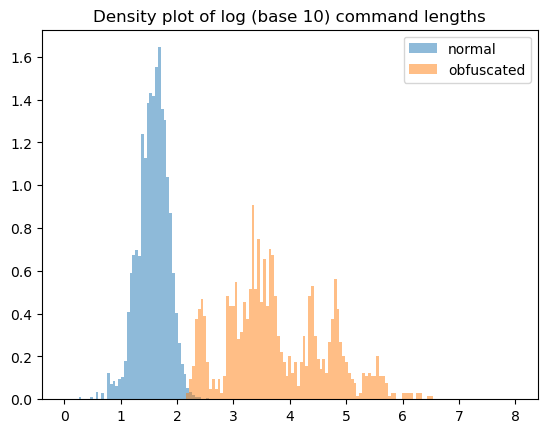

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Compute log (base 10) lengths of normal and obfuscated commands
len_nor = [len(elem) for elem in nor_text]
loglen_nor = np.log10(len_nor)

len_mal = [len(elem) for elem in mal_text]
loglen_mal = np.log10(len_mal)

# Evalute max of log lengths
print('Max. log length for normal commands: ' + str(np.max(loglen_nor)))
print('Max. log length for obfuscated commands: ' + str(np.max(loglen_mal)))

# Plot density
bins = np.linspace(0, 8, 160)
plt.hist(loglen_nor, bins, density=True, alpha=0.5, label='normal')
plt.hist(loglen_mal, bins, density=True, alpha=0.5, label='obfuscated')
plt.legend(loc='upper right')
plt.title('Density plot of log (base 10) command lengths')

from matplotlib import rcParams
rcParams['figure.figsize'] = [8,6]
plt.show()

In [5]:
# Truncate obfuscated commands
truncate = True
hard_truncate = False
max_length = 100

if truncate:
    if hard_truncate:
        # Truncate all obfuscated commands at specified max length
        mal_text = [elem[:max_length] for elem in mal_text]
    else:
        # Truncate obfuscated commands according to normal command length distribution
        mal_text = [elem[:random.choice(len_nor)] for elem in mal_text]

## Feature extraction
We now perform feature extraction on a labeled dataset comprised of both normal and obfuscated commands. To do this, we will use the `CountVectorizer` function in scikit-learn to generate a set of features based on $n$-grams of words or characters (or some other user-specified criterion), then compute the number of occurrences of every feature within each command. Each such count vector can be thought of a vector representation (e.g., an embedding) of the command from which it was generated.

In [15]:
# Merge normal/obfuscated commands into one labeled dataset
raw_text = nor_text + mal_text
raw_labels = [-1]*num_nor + [1]*num_mal

["top -b -d2 -s1 | sed -e '1,/USERNAME/d' | sed -e '1,/^$/d'", "top -b -n 1 -u abc | awk 'NR>7 { sum += $9; } END { print sum; }'", 'top -b -d 5 -n 2 | awk \'$1 == "PID" {block_num++; next} block_num == 2 {sum += $9;} END {print sum}\'', 'top -n 1', 'top -bn1 | grep zombie', "top -bn1 | sed -n '/Cpu/p'", 'top -bn1 | grep zombie | awk \'{print $4" "$6" "$8" "$10}\'', 'top -b -n1 -c', 'top -b -n1 | grep processname', "top -n1 | sed 's/\\(.*\\)$/\\1__CUSTOM_LINE_MARKER/g'", "top -bn1 | sed -n '/Cpu/p' | awk '{print $2}' | sed 's/..,//'", 'top -b -n1 | head -8 | tail -1 | awk \'{ printf "User: %s\\nPID: %s\\nCPU Usage: %s\\nMEM Usage: %s\\n", $2,$1,$9,$10 }\'', "top -b -n1 -c  | awk '/PID *USER/{print;getline;print}'", "top -b -n1 -c  | grep -A 2 '^$'", 'top -u abc -d 30 -b -n 10', "top -p $(pgrep -d',' http)", 'top -p "$(pgrep -d \',\' java)"', 'top -p `pgrep process-name | tr "\\\\n" "," | sed \'s/,$//\'`', "top -c -p $(pgrep -d',' -f string_to_match_in_cmd_line)", 'top -c', "LINE=$(top 

In [17]:
# Build feature extractor
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
#count_vect = CountVectorizer()  # word feature extraction
count_vect = CountVectorizer(analyzer='char', ngram_range=(1,2))  # character n-gram feature extraction

# Extract feature counts
raw_counts = count_vect.fit_transform(raw_text)

# Display features
features = count_vect.get_feature_names()
print('Feature set: ' + str(features))
print('Number of features: ' + str(len(features)))

Feature set: ['\t', '\t+', '\t\\', '\tm', ' ', ' !', ' "', ' #', ' $', ' %', ' &', " '", ' (', ' )', ' *', ' +', ' ,', ' -', ' .', ' /', ' 0', ' 1', ' 2', ' 3', ' 4', ' 5', ' 6', ' 7', ' 8', ' 9', ' :', ' ;', ' <', ' =', ' >', ' ?', ' @', ' [', ' \\', ' ]', ' ^', ' _', ' `', ' a', ' b', ' c', ' d', ' e', ' f', ' g', ' h', ' i', ' j', ' k', ' l', ' m', ' n', ' o', ' p', ' q', ' r', ' s', ' t', ' u', ' v', ' w', ' x', ' y', ' z', ' {', ' |', ' }', ' ~', ' «', ' \xad', ' à', ' а', ' –', ' —', ' ‘', ' ’', ' “', ' ”', ' …', ' ╲', '!', '! ', '!!', '!"', '!#', '!%', "!'", '!(', '!*', '!.', '!/', '!0', '!7', '!:', '!=', '!>', '!@', '!\\', '!_', '!b', '!c', '!d', '!e', '!g', '!h', '!m', '!o', '!p', '!r', '!s', '!x', '!z', '!{', '!}', '!~', '"', '" ', '"!', '""', '"#', '"$', '"%', '"&', '"\'', '"(', '")', '"*', '"+', '",', '"-', '".', '"/', '"0', '"1', '"2', '"3', '"5', '"7', '"9', '":', '";', '"<', '"=', '">', '"?', '"@', '"[', '"\\', '"]', '"^', '"_', '"`', '"a', '"b', '"c', '"d', '"e', '"f', 

In [8]:
# Normalize counts
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False)
all_data = tf_transformer.fit_transform(raw_counts)

# Convert labels to numpy array
import numpy as np
all_labels = np.asarray(raw_labels)

# Create set of indices
indices = np.arange(len(all_labels))

## Train/test split
In order to not overfit the model and miscalculate its true performance, we must first split the dataset into a training set and a test set. In the following sections, we will train a model using feature vectors and corresponding labels from the training set (see **Model training**), and evaluate its performance by predicting labels using only feature vectors from the test set (see **Inference**).

In [9]:
# Create train/test split
from sklearn.model_selection import train_test_split

# Include indices for tracking of individual data points after splitting
train_data, test_data, train_labels, test_labels, train_indices, test_indices = train_test_split(all_data, all_labels, indices, test_size=0.5, random_state=0)

## Model training
Next, we can train a classifier that tries to learn which parts of the feature space correspond to each of the two classes: normal vs. obfuscated. We will focus on logistic regression (a linear model) and random forest (a non-linear, ensemble method) in order to illustrate how these classifiers can be utilized, and will later show how their results can be analyzed and interpreted.

### Random forest (ensemble of decision trees)


In [10]:
# Train a random forest classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=250, max_depth=5, random_state=0).fit(train_data, train_labels)
classifier_type = 'random forest'

In [11]:
# Train a decision tree classifier
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth=5).fit(train_data, train_labels)
classifier_type = 'decision tree'

### Logistic regression

In [12]:
# Train a logistic regression classifier using stochastic gradient descent (SGD)
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss='log', penalty='none', random_state=0).fit(train_data, train_labels)
classifier_type = 'logistic regression'

## Inference
In this section, we apply the trained classifier to the test set and study its performance using a series of metrics. We can also take a closer look at those examples that were misclassified and try to discern the reasons why prediction failed. To do this, we inspect coefficients within the trained model in order gain a better understanding of what it has learned and how it could potentially be improved.

In [13]:
# Predict labels for test data
predicted_labels = classifier.predict(test_data)

### Analyze performance
We consider the performance of our classifier by looking at metrics such as precision, recall, F1-measure, and accuracy. These can also be built using the confusion matrix, which is essentially a histogram of the predicted labels and true lables of examples in the test set.

In [14]:
# Analyze performance
from sklearn import metrics

# Classification report
#print(metrics.classification_report(test_labels, predicted_labels))

# Standard metrics
precision = metrics.precision_score(test_labels, predicted_labels)
recall = metrics.recall_score(test_labels, predicted_labels)
f1measure = metrics.f1_score(test_labels, predicted_labels)
accuracy = metrics.accuracy_score(test_labels, predicted_labels)

print(' precision = ' + str(precision))
print('    recall = ' + str(recall))
print('F1-measure = ' + str(f1measure))
print('  accuracy = ' + str(accuracy))
print('\n')

# Confusion matrix
print('Confusion matrix (text-only):')
cm = metrics.confusion_matrix(test_labels, predicted_labels, classifier.classes_)
print(classifier.classes_)
print(cm)

 precision = 0.9937106918238994
    recall = 0.9937106918238994
F1-measure = 0.9937106918238994
  accuracy = 0.9988472622478386


Confusion matrix (text-only):


TypeError: confusion_matrix() takes 2 positional arguments but 3 were given

In [ ]:
# Plot fancy confusion matrix
# Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=4)


# Pretty plot non-normalized confusion matrix
plot_confusion_matrix(test_labels, predicted_labels, classes=['normal','obfuscated'],
                      title='Confusion matrix, without normalization')

# Pretty plot normalized confusion matrix
plot_confusion_matrix(test_labels, predicted_labels, classes=['normal','obfuscated'], normalize=True,
                      title='Normalized confusion matrix, by true label')

#from matplotlib import rcParams
rcParams['figure.figsize'] = [6,6]
plt.show()

### Inspect misclassified examples
By looking at those examples that were misclassified, we can better understand what the classifier has learned and how it could potentially be improved. In our case, each misclassified example is either (i) a command marked as obfuscated although it was actually normal (i.e., a false positive) or (ii) a command marked as normal although it was actually obfuscated (i.e., a false negative). It is largely domain-dependent to determine how to balance the cost of a false negative versus a false positive, and which we'd prefer our model to try to avoid.

In [ ]:
# Show misclassified examples
misclassified_fp = np.where((test_labels != predicted_labels) & (predicted_labels == np.ones(len(predicted_labels))))
misclassified_fn = np.where((test_labels != predicted_labels) & (predicted_labels != np.ones(len(predicted_labels))))

false_positives = [raw_text[index] for index in test_indices[misclassified_fp]]
print('False positives (marked as obfuscated, but actually normal):')
for elem in false_positives:
    print(elem)
print('\n')

false_negatives = [raw_text[index] for index in test_indices[misclassified_fn]]
print('False negatives (marked as normal, but actually obfuscated):')
for elem in false_negatives:
    print(elem)

### Explain model results by analyzing feature importance
Finally, we would like to inspect our trained model more closely to try to determine how it is making its predictions. This largely depends entirely on the model we are training, although there are several model-agnostic methods for interpretability that we won't discuss here.

#### Random forest (or decision trees)

In [ ]:
import pandas as pd

if classifier_type in ['decision tree', 'random forest']:

    # Compute feature importances
    importance_scores = classifier.feature_importances_
    feature_importances = pd.DataFrame(importance_scores, index = features,
                                columns=['importance']).sort_values('importance', ascending=False)

    print('Top features based on (averaged) Gini index:')
    print(feature_importances[:20])

    # Extract (sample) decision tree
    if classifier_type == 'decision tree':
        sample_tree = classifier
    if classifier_type == 'random forest':
        sample_tree = random.choice(classifier.estimators_)

    # Plot decision tree
    from sklearn.tree import plot_tree
    plot_tree(sample_tree, feature_names=features, filled=True)

    from matplotlib import rcParams
    rcParams['figure.figsize'] = [18,10]
    print('\n')
    print('(Sampled) decision tree:')
    plt.show()

else:
    print("Invalid: Train tree-based classifier.")

#### Logistic regression

In [ ]:
import pandas as pd

if classifier_type == 'logistic regression':

    # CompUte feature importances
    importance_scores = np.transpose(classifier.coef_)
    feature_importances = pd.DataFrame(importance_scores, index = features,
                                columns=['importance']).sort_values('importance', ascending=False)

    # Display most important features for each class
    print('Features that favor obfuscated class:')
    print(feature_importances[:10])
    print('\n')
    print('Features that favor normal class:')
    print(feature_importances[-10:])

else:
    print("Invalid: Train logistic regression classifier.")